In [3]:
#import packages
from io import open
import os, string, random, time, math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [4]:

from sklearn.model_selection import train_test_split
import torch 
import torch.nn as nn
import torch.optim as optim

#clearing output
from IPython.display import clear_output

In [5]:
languages = []
data = []
X = []
y = []

In [6]:
MIN_OCCURENCE = 3

def process_data(base_path):
    df = pd.read_csv(base_path)
    df = df[df.last_name != "lnu"]  # Remove last name unknows
    df = df[
        df.groupby("last_name")["last_name"].transform("count").ge(MIN_OCCURENCE)
    ]  # Remove all last names that occur less than MIN_OCCURANCE times
    df = df[(df.state != "wb")]
    df = df[(df.state != "tn")]
    df = df[df.last_name.str.len() > 2]
    return df

In [7]:
base_dir = "/Users/dhingratul/Documents/instate_data"
fid = "instate_processed.csv.gz"
# Data
print("Processing data")
df = process_data(os.path.join(base_dir, fid))

Processing data


FileNotFoundError: [Errno 2] No such file or directory: '/Users/dhingratul/Documents/instate_data/instate_processed.csv.gz'

In [8]:
def split_tr_te(df):
    samplelist = df["last_name"].unique()
    training_samp, test_samp = train_test_split(
        samplelist, train_size=0.8, test_size=0.2, random_state=5, shuffle=True
    )
    training_data = df[df["last_name"].isin(training_samp)]
    test_data = df[df["last_name"].isin(test_samp)]
    return training_data, test_data

In [9]:
# TODO: Rename to reflect logic
def prepare_test_data(df):
    category_lines = (
        df.groupby(["last_name"])["state"]
        .apply(lambda grp: list(grp.value_counts().index))
        .to_dict()
    )
    all_names = list(category_lines.keys())
    return all_names, category_lines


def prepare_train_data(df):
    category_lines = (
        df.groupby(["state"])["last_name"]
        .apply(lambda grp: list(grp.value_counts().index))
        .to_dict()
    )
    all_categories = list(category_lines.keys())
    return category_lines, all_categories

In [40]:
training_data, test_data = split_tr_te(df)

In [10]:
training_data = pd.read_csv("/data/Documents/instate/data/training_data.csv.gz")

In [11]:
training_data.head()

,state,last_name
0,andaman,devi
1,andaman,krishna
2,andaman,sekhar
3,andaman,toppo
4,andaman,kiran


In [12]:
training_data = training_data[training_data.last_name.str.len() > 2]

In [13]:
test_data = pd.read_csv("/data/Documents/instate/data/test_data.csv.gz")

In [14]:
test_data = test_data[test_data.last_name.str.len() > 2]

In [15]:
test_data.head()

,state,last_name
0,andaman,datta
1,andaman,ekka
2,andaman,ekka
3,andaman,yadav
4,andaman,singh


In [16]:
X_tr, y_tr = prepare_train_data(training_data)
X_te, y_te = prepare_test_data(test_data)

In [18]:
X_tr.keys()

dict_keys(['andaman', 'andhra', 'arunachal', 'assam', 'bihar', 'chandigarh', 'dadra', 'daman', 'delhi', 'goa', 'guj', 'har', 'jha', 'jk', 'kar', 'kerala', 'maharashtra', 'manipur', 'meghalaya', 'mizoram', 'mp', 'nagaland', 'odi', 'puducherry', 'punjab', 'rajasthan', 'sikkim', 'tel', 'tripura', 'up', 'utt'])

In [19]:
states = y_tr
n_states = len(states)

In [20]:
all_letters = string.ascii_letters + ".,;"
n_letters = len(all_letters)

In [21]:
def name_rep(name):
    rep = torch.zeros(len(name), 1, n_letters)
    for index, letter in enumerate(name):
        pos = all_letters.find(letter)
        rep[index][0][pos] = 1
    return rep

In [22]:
name_rep("Dutta")

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [24]:
device

device(type='cuda')

In [25]:
#define a basic rnn network

class RNN_net(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_net, self).__init__()
        #declare the hidden size for the network
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size) #input to hidden layer
        self.i2o = nn.Linear(input_size + hidden_size, output_size) #input to output layer
        self.softmax = nn.LogSoftmax(dim = 1) #softmax for classification
    
    def forward(self, input_, hidden):
        combined = torch.cat((input_.to(device), hidden.to(device)), 1) #concatenate tensors on column wise
        hidden = self.i2h(combined) #generate hidden representation
        output = self.i2o(combined) #generate output representation
        output = self.softmax(output) #get the softmax label
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size).to(device)

In [26]:

#declare the size of the hidden layer representation
n_hidden = 128
#create a object of the class
net = RNN_net(n_letters, n_hidden, n_states)
net = net.to(device)

In [27]:
#function to make inference

def infer(net, name):
    net.eval()
    name_ohe = name_rep(name).to(device)
    hidden = net.init_hidden()

    for i in range(name_ohe.size()[0]):
        output, hidden = net(name_ohe[i], hidden)

    return output

In [28]:
name = "Dutta"
name_ohe = name_rep(name).to(device)

In [29]:
name_ohe.device

device(type='cuda', index=0)

In [30]:
#before training the network, make a inference to test the network

output = infer(net, "Dutta")
index = torch.argmax(output)
print(output, index)
     

tensor([[-3.4698, -3.4710, -3.4438, -3.4750, -3.4661, -3.5282, -3.5460, -3.3257,
         -3.3396, -3.5801, -3.4080, -3.3754, -3.3126, -3.4073, -3.4026, -3.4388,
         -3.3929, -3.5163, -3.4730, -3.5766, -3.4295, -3.3225, -3.4460, -3.4819,
         -3.3865, -3.3797, -3.3487, -3.4589, -3.5060, -3.3700, -3.4534]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>) tensor(12, device='cuda:0')


In [31]:
# Training Data
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]


def randomTrainingExample(X, y):
    category = randomChoice(y)
    line = randomChoice(X[category])
    category_tensor = torch.tensor([y.index(category)], dtype=torch.long).to(device)
    line_tensor = name_rep(line).to(device)
    return category, line, category_tensor, line_tensor

In [32]:
#create a dataloader
def dataloader(npoints, X_, y_):
    to_ret = []
    for i in range(npoints):
        state, name, state_tensor, name_tensor = randomTrainingExample(X_, y_)
        to_ret.append((name, state, name_tensor, state_tensor))
    return to_ret

In [33]:
randomTrainingExample(X_tr, y_tr)

('manipur',
 'buhini',
 tensor([17], device='cuda:0'),
 tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [34]:
dataloader(1, X_tr, y_tr)

[('వనజ',
  'tel',
  tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 1.]],
  
          [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 1.]],
  
          [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 1.]]], device='cuda:0'),
  tensor([27], device='cuda:0'))]

In [35]:
#function to create lang representation

def nat_rep(state):
    return torch.tensor([states.index(state)], dtype = torch.long)

In [40]:
def dataloader_te(npoints, X_, y_):
    random.seed(9001)
    # Adds top-3 states
    to_ret = []
    for i in range(npoints):
        index_ = np.random.randint(0, len(X_) - 1)
        if  len(y_[X_[index_]]) > 3:
            top_3 = 3
        else:
            top_3 = len(y_[X_[index_]])
        for i in range(top_3):
            name, state = X_[index_], y_[X_[index_]][i] #get the data at the random index
            to_ret.append((name, state, name_rep(name).to(device), nat_rep(state).to(device)))
    return to_ret

In [41]:
dataloader_te(1, X_te, y_te)

[('basudor',
  'andhra',
  tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0.]],
  
          [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0.]],
  
          [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0.]],
  
          [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [271]:
# def eval_all(net, k, X_te, y_te):
#     top_k = 3
#     correct = 0
#     for index_ in range(len(X_te)):
#         top_3_gt = []
# #         if index_ % 1000:
# #             print(f"Processing : {index_}/{len(X_te)}")
#         name, state = X_te[index_], set(y_te[X_te[index_]][:top_k])
#         output = infer(net, name) #prediction
#         val, indices = output.topk(k) #get the top k predictions
#         for _state in state:  
#             top_3_gt.append(nat_rep(_state).item()) # .item() gets the value
#         if bool(set(top_3_gt) & set(indices.cpu().numpy().flatten().tolist())):
#             correct += 1
#     accuracy = correct/len(X_te)
#     return accuracy

In [42]:
def eval_all(net, k, X_te, y_te):
    top_k = 3
    correct = 0
    pred_arr = []
    for index_ in range(len(X_te)):
        top_3_gt = []
#         if index_ % 1000:
#             print(f"Processing : {index_}/{len(X_te)}")
        name, state = X_te[index_], set(y_te[X_te[index_]][:top_k])
        output = infer(net, name) #prediction
        val, indices = output.topk(k) #get the top k predictions
        for _state in state:  
            top_3_gt.append(nat_rep(_state).item()) # .item() gets the value
        if bool(set(top_3_gt) & set(indices.cpu().numpy().flatten().tolist())):
            correct += 1
            pred_arr.append(1)
        else:
            pred_arr.append(0)
    accuracy = correct/len(X_te)
    return accuracy, pred_arr

In [43]:
#create a function to evaluate model

def eval(net, n_points, k, X_, y_):
     data_ = dataloader_te(n_points, X_, y_)
     correct = 0

     for name, language, name_ohe, lang_rep in data_:
         output = infer(net, name) #prediction
         val, indices = output.topk(k) #get the top k predictions

         if lang_rep in indices:
             correct += 1
    
     accuracy = correct/n_points
     return accuracy

In [44]:

#function to train the data
m = nn.LogSoftmax(dim=1)

def train(net, opt, criterion, n_points):
    
    opt.zero_grad()
    total_loss = 0
    
    data_ = dataloader(n_points, X_tr, y_tr)
    
    for name, language, name_ohe, lang_rep in data_:

        hidden = net.init_hidden()

        for i in range(name_ohe.size()[0]):
            output, hidden = net(name_ohe[i], hidden)
#         loss = criterion(output, lang_rep)    
        loss = criterion(m(output), lang_rep)
        loss.backward(retain_graph=True)
#         torch.nn.utils.clip_grad_norm_(net.parameters(), 0.25)
        
        total_loss += loss
        
    opt.step()       
            
    return total_loss/n_points

In [ ]:

#function to train the data
m = nn.LogSoftmax(dim=1)

def eval_setup(net, opt, criterion, n_points):
    
    opt.zero_grad()
    total_loss = 0
    
    data_ = dataloader(n_points, X_te, y_te)
    
    for name, language, name_ohe, lang_rep in data_:

        hidden = net.init_hidden()

        for i in range(name_ohe.size()[0]):
            output, hidden = net(name_ohe[i], hidden)
#         loss = criterion(output, lang_rep)    
        loss = criterion(m(output), lang_rep)
        loss.backward(retain_graph=True)
#         torch.nn.utils.clip_grad_norm_(net.parameters(), 0.25)
        
        total_loss += loss
        
    opt.step()       
            
    return total_loss/n_points

In [45]:
def train_setup(net, lr = 0.01, n_batches = 100, batch_size = 10, momentum = 0.9, display_freq = 5, fid='net_eval.txt', eval_step = 250):

    criterion = nn.NLLLoss() #define a loss function
#     opt = optim.SGD(net.parameters(), lr = lr, momentum = momentum) #define a optimizer
    opt = optim.Adam(net.parameters(), lr = lr) #define a optimizer
    loss_arr = np.zeros(n_batches + 1)

    #iterate through all the batches
    for i in range(n_batches):
        loss_arr[i + 1] = (loss_arr[i]*i + train(net, opt, criterion, batch_size))/(i + 1)
        if i % eval_step == 0:
            with open(fid, 'a') as f:
                f.write(f"n_batches:{i}, loss:{round(loss_arr[i],4)}\n")

        if i%display_freq == display_freq - 1:
            clear_output(wait = True)

            print("Iteration number ", i + 1, 'Loss:', round(loss_arr[i],4))
            plt.figure()
            plt.plot(loss_arr[1:i], "-*")
            plt.xlabel("Iteration")
            plt.ylabel("Loss")
            plt.show()
            print("\n\n")


In [50]:
random.seed(9001)
eval_test_set = np.random.choice(X_te, 256)

Iteration number  10000 Loss: 2.695


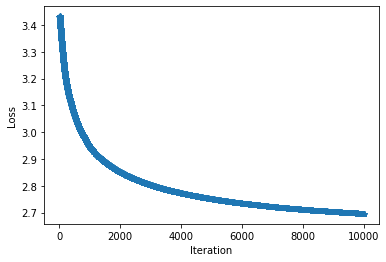

In [57]:

#declare all the parameters

n_hidden = 512
net_rnn = RNN_net(n_letters, n_hidden, n_states)
net_rnn = net_rnn.to(device)
train_setup(net_rnn, lr = 3e-4, n_batches = 10000, batch_size =256 ,  fid='net_rnn_eval.txt')

In [58]:
acc_rnn, pred_array_rnn = eval_all(net_rnn, 3, X_te, y_te)

In [61]:
print(acc_rnn)

0.6527992192352053


In [62]:
#LSTM class

class LSTM_net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM_net, self).__init__()
        self.hidden_size = hidden_size
        self.lstm_cell = nn.LSTM(input_size, hidden_size) #LSTM cell
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim = 2)

    def forward(self, input_, hidden):
        out, hidden = self.lstm_cell(input_.view(1, 1, -1), hidden)
        output = self.h2o(hidden[0])
        output = self.softmax(output)
        return output.view(1, -1), hidden

    def init_hidden(self):
        return (torch.zeros(1, 1, self.hidden_size).to(device), torch.zeros(1, 1, self.hidden_size).to(device))

Iteration number  10000 Loss: 2.4012


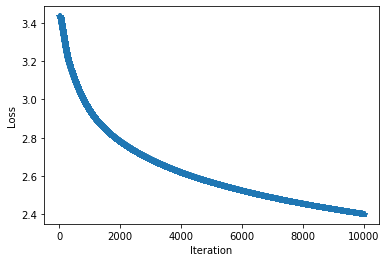

In [63]:
#create hyperparameters
n_hidden = 512
net_lstm = LSTM_net(n_letters, n_hidden, n_states)
net_lstm = net_lstm.to(device)
train_setup(net_lstm, lr = 3e-4, n_batches = 10000, batch_size = 256, fid='net_lstm_eval.txt')

In [64]:
acc_lstm, pred_array_lstm = eval_all(net_lstm, 3, X_te, y_te)

In [65]:
print(acc_lstm)

0.759142933191376


In [66]:
#GRU implementation

class GRU_net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRU_net, self).__init__()
        self.hidden_size = hidden_size
        self.gru_cell = nn.GRU(input_size, hidden_size) #gru cell
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim = 2)
    
    def forward(self, input_, hidden):
        out, hidden = self.gru_cell(input_.view(1, 1, -1), hidden)
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output.view(1, -1), hidden
    
    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size).to(device)

Iteration number  10000 Loss: 1.8971


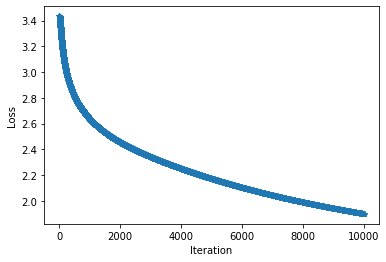

In [67]:
#hyperparameters

n_hidden = 2048
net_gru = GRU_net(n_letters, n_hidden, n_states)
net_gru = net_gru.to(device)
train_setup(net_gru, lr = 3e-4, n_batches = 10000, batch_size = 1024,fid='net_gru_eval.txt')

In [68]:
acc_gru, pred_array_gru = eval_all(net_gru, 3, X_te, y_te)

In [69]:
print(acc_gru)

0.8530786975423653


In [70]:
torch.save(net_gru, "instate_gru.pt")
torch.save(net_gru.state_dict(), "instate_gru.pth")

In [71]:
torch.save(net_lstm, "instate_lstm.pt")
torch.save(net_lstm.state_dict(), "instate_lstm.pth")

In [72]:
torch.save(net_rnn, "instate_rnn.pt")
torch.save(net_rnn.state_dict(), "instate_rnn.pth")

In [73]:
# By name popularity
count_uniques = test_data["last_name"].value_counts(normalize=True)
count_uniques_un = test_data["last_name"].value_counts()

In [74]:
count_uniques[:10]

kumaar      0.294437
khaathun    0.026987
daas        0.026883
prakaas     0.021697
kumar       0.011297
chandr      0.011273
varmaa      0.010961
lakshman    0.009190
naaeka      0.008827
singh       0.008110
Name: last_name, dtype: float64

In [75]:
# Accuracy on top-3000 most occuring names
X_te_top_3k = count_uniques.index[:3000]
eval_all(net_gru, 3, X_te_top_3k, y_te)

(0.8243333333333334,
 [1,
  1,
  1,
  1,
  0,
  1,
  0,
  0,
  1,
  0,
  1,
  1,
  1,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  1,
  1,
  1,
  0,
  1,
  0,
  0,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  0,
  1,

In [76]:
# Accuracy on top-3000 most occuring names
eval_all(net_lstm, 3, X_te_top_3k, y_te)

(0.731,
 [0,
  1,
  1,
  1,
  0,
  0,
  0,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  1,
  1,
  1,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  1,
  1,
  0,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  1,
  

In [77]:
# Accuracy on top-3000 most occuring names
eval_all(net_rnn, 3, X_te_top_3k, y_te)

(0.6276666666666667,
 [0,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  1,
  1,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  1,
  1,
  0,
  1,
  0,
  0,
  0,
  1,
  1,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  1,
  1,
  0,
  0,
  0,
  1,
  1,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  0,
  0,
  1,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  1,
  1,
  1,
  0,
  0,
  0,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  1,
  0,
  1,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  0,
  0,
  0,

In [78]:
# Accuracy on bottom-3k most occuring names
X_te_bottom_3k = count_uniques.index[-3000:]
eval_all(net_gru, 3, X_te_bottom_3k, y_te)

(0.8196666666666667,
 [0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  0,
  0,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,

In [79]:
# Accuracy on bottom-3k most occuring names
eval_all(net_lstm, 3, X_te_bottom_3k, y_te)

(0.724,
 [0,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  0,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  0,
  0,
  0,
  1,
  

In [80]:
# Accuracy on bottom-10000 most occuring names
eval_all(net_rnn, 3, X_te_bottom_3k, y_te)

(0.623,
 [0,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  1,
  1,
  0,
  1,
  1,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  0,
  0,
  1,
  1,
  0,
  1,
  0,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  0,
  0,
  1,
  0,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  1,
  

In [81]:
te_freq = count_uniques.reset_index()
te_freq_un = count_uniques_un.reset_index()
te_names_counts = te_freq["index"].tolist()
te_names_counts_freq = te_freq["last_name"].tolist()
### Weighted random sample
random.seed(9001)
X_te_weighted = np.random.choice(te_names_counts, 3000, te_names_counts_freq)
X_te_random = np.random.choice(te_names_counts, 3000)

In [82]:
eval_all(net_gru, 3, X_te_weighted, y_te)

(0.8413333333333334,
 [1,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,

In [83]:
eval_all(net_lstm, 3, X_te_weighted, y_te)

(0.7536666666666667,
 [1,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  0,
  0,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  0,
  0,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,

In [84]:
eval_all(net_rnn, 3, X_te_weighted, y_te)

(0.654,
 [1,
  0,
  1,
  0,
  1,
  0,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  0,
  0,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  0,
  0,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  0,
  0,
  1,
  1,
  0,
  0,
  1,
  0,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  0,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  

In [85]:
eval_all(net_gru, 3, X_te_random, y_te)

(0.8543333333333333,
 [1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,

In [86]:
eval_all(net_lstm, 3, X_te_random, y_te)

(0.758,
 [1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  0,
  0,
  1,
  1,
  0,
  1,
  1,
  

In [87]:
eval_all(net_rnn, 3, X_te_random, y_te)

(0.646,
 [1,
  1,
  0,
  0,
  1,
  1,
  1,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  0,
  0,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  0,
  1,
  0,
  0,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  0,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  0,
  0,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  0,
  0,
  1,
  1,
  0,
  0,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  0,
  

In [230]:
# ANalysis
res = pd.read_csv("log_10k.csv")

In [231]:
res.head()

,Unnamed: 0,_name,y_pred,top_3_pred,top_1_gt,pred
0,0,mistry,mishtry,"['dadra', 'delhi']",andaman,0
1,1,madhavi,madhavji,['andhra'],andaman,0
2,2,mondal,moondal,"['up', 'mp', 'maharashtra']",andaman,0
3,3,mondal,moondal,"['up', 'mp', 'maharashtra']",andaman,0
4,4,swamy,swsamy,['andhra'],andaman,0


In [227]:
X_te_res = res["_name"].tolist()
y_te_res = res["top_1_gt"].tolist()

In [222]:
top_3_strat = []
for i, _x in enumerate(X_te_res):
    y_gt = y_te_res[i]
    output = infer(net_gru, _x) #prediction
    val, indices = output.topk(3) #get the top k predictions
    if nat_rep(y_gt).to(device) in indices:
        top_3_strat.append(1)
    else:
        top_3_strat.append(0)
print(f"Top-3 Accuracy: {sum(top_3_strat)/ len(top_3_strat)*100}")

Top-3 Accuracy: 59.84677198692378


In [232]:
res["pred_gru"] = top_3_strat

In [233]:
res.head()

,Unnamed: 0,_name,y_pred,top_3_pred,top_1_gt,pred,pred_gru
0,0,mistry,mishtry,"['dadra', 'delhi']",andaman,0,1
1,1,madhavi,madhavji,['andhra'],andaman,0,0
2,2,mondal,moondal,"['up', 'mp', 'maharashtra']",andaman,0,1
3,3,mondal,moondal,"['up', 'mp', 'maharashtra']",andaman,0,1
4,4,swamy,swsamy,['andhra'],andaman,0,1


In [234]:
# Baseline
res_baseline = (res.groupby("top_1_gt").apply(lambda x: x["pred"].sum()/len(x["pred"]))*100).reset_index(name='baseline')

In [235]:
# LSTM
res_gru = (res.groupby("top_1_gt").apply(lambda x: x["pred_gru"].sum()/len(x["pred_gru"]))*100).reset_index(name='GRU')

In [236]:
res_all = pd.merge(res_baseline,res_gru,on='top_1_gt')

In [237]:
res_all

,top_1_gt,baseline,GRU
0,andaman,14.661879,69.569120
1,andhra,79.720930,62.976744
2,arunachal,28.310078,69.023256
3,assam,16.713178,95.317829
4,bihar,31.720930,3.689922
5,chandigarh,1.302326,42.232558
6,dadra,28.899225,73.085271
7,daman,12.806202,62.697674
8,delhi,63.937984,33.581395
9,goa,27.844961,43.937984


In [88]:
acc, pred_arr_lstm = eval_all(net_lstm, 3, X_te_weighted, y_te)
acc, pred_arr_rnn = eval_all(net_rnn, 3, X_te_weighted, y_te)
acc, pred_arr_gru = eval_all(net_gru, 3, X_te_weighted, y_te)

te_names_states = []
for _name in X_te_weighted:
    te_names_states.append(y_te[_name])

total_freq_weighted_n = []
for _name in X_te_weighted:
    total_freq_weighted_n.append(float(te_freq[te_freq["index"]==_name]["last_name"].values))

total_freq_weighted_un = []
for _name in X_te_weighted:
    total_freq_weighted_un.append(float(te_freq_un[te_freq_un["index"]==_name]["last_name"].values))

In [89]:
out_df = pd.DataFrame({"last_name":X_te_weighted, "total_freq_n":total_freq_weighted_n, "total_freq":total_freq_weighted_un, "gt_state":te_names_states, "lstm_pred":pred_arr_lstm, "rnn_pred":pred_arr_rnn, "gru_pred":pred_arr_gru})

In [90]:
out_df.head()

,last_name,total_freq_n,total_freq,gt_state,lstm_pred,rnn_pred,gru_pred
0,muphees,1.421982e-06,122.0,"[up, maharashtra, guj, mp]",1,1,1
1,raanoobaai,3.496676e-08,3.0,[maharashtra],1,0,1
2,pilibhamtara,3.496676e-08,3.0,[kar],1,1,1
3,shamsani,3.496676e-08,3.0,[andhra],0,0,0
4,njjaadaakaa,4.662235e-08,4.0,[odi],1,1,1


In [93]:
test_data.head()

,state,last_name
0,andaman,datta
1,andaman,ekka
2,andaman,ekka
3,andaman,yadav
4,andaman,singh


In [98]:
test_data_clean =  test_data[test_data["last_name"].str.contains('[a-z]',  na=False)]

In [108]:
size = 1000        # sample size
replace = True  # with replacement
random.seed(9001)
fn = lambda obj: obj.loc[np.random.choice(obj.index, size, replace),:]
strat_data = test_data_clean.groupby('state', as_index=False).apply(fn)

In [109]:
strat_data.iloc[::999, :]

state        last_name
0  21764         andaman           kumari
   320           andaman           mistry
1  6285654        andhra           kothur
2  129541      arunachal             megu
3  7058266         assam             daas
4  12418385        bihar              sih
5  20331180   chandigarh           kumaar
6  225294          dadra         gajubhai
7  237027          daman             bica
8  21855701        delhi            kumar
9  394722            goa         silveira
10 24236538          guj  mumathaajhhaben
11 30587261          har          jhhaamb
12 32994093          jha           kumaar
13 523191             jk          namgial
14 34634955          kar            kaale
15 35336009       kerala             naik
16 50695113  maharashtra         lakshman
17 636578        manipur             bibi
18 999885      meghalaya           sangma
19 1393636       mizoram              joi
20 52664034           mp          dhaakad
21 1451313      nagaland            zhimo
22 57393950          odi        hudaaൟtha
23 1490794    puducherry            pappu
24 61111312       punjab           kumaar
25 62620674    rajasthan           kumaar
26 65766287       sikkim          chettri
27 65892515          tel              ots
28 66646037      tripura        debanaath
29 71864306           up           kumaar
30 85732217          utt           kumaar

In [110]:
len(strat_data["state"].unique())

31

In [111]:
strat_data.shape

(31000, 2)

In [112]:
X_te_strat=strat_data["last_name"].tolist()

In [120]:
strat_data["pred_lstm"]=pred_arr_lstm_strat
strat_data["pred_rnn"]=pred_arr_rnn_strat
strat_data["pred_gru"]=pred_arr_gru_strat

In [121]:
strat_data.head()

state     last_name  pred_lstm  pred_rnn  pred_gru
0 21764  andaman        kumari          0         0         1
  56953  andaman      howlader          1         0         1
  17218  andaman         durai          0         0         1
  53711  andaman         johnf          1         0         1
  29370  andaman  chakraborthy          1         1         1

In [114]:
acc_strat_lstm, pred_arr_lstm_strat = eval_all(net_lstm, 3, X_te_strat, y_te)
print(f"LSTM Acc: {acc_strat_lstm}")
acc_strat_rnn, pred_arr_rnn_strat = eval_all(net_rnn, 3, X_te_strat, y_te)
print(f"RNN Acc: {acc_strat_rnn}")
acc_strat_gru, pred_arr_gru_strat = eval_all(net_gru, 3, X_te_strat, y_te)
print(f"GRU Acc: {acc_strat_gru}")

LSTM Acc: 0.6013225806451613
RNN Acc: 0.47951612903225804
GRU Acc: 0.7943870967741935


In [115]:
len(pred_arr_lstm_strat)

31000

In [124]:
# Per state analysis
acc_strat_state_lstm = (strat_data.groupby("state").apply(lambda x: x["pred_lstm"].sum()/len(x["pred_lstm"]))*100)
acc_strat_state_rnn = (strat_data.groupby("state").apply(lambda x: x["pred_rnn"].sum()/len(x["pred_rnn"]))*100)
acc_strat_state_gru = (strat_data.groupby("state").apply(lambda x: x["pred_gru"].sum()/len(x["pred_gru"]))*100)

In [129]:
acc_strat_state = pd.concat({"RNN":acc_strat_state_rnn, "LSTM":acc_strat_state_lstm, "GRU":acc_strat_state_gru},axis=1)

In [130]:
acc_strat_state

,RNN,LSTM,GRU
state,,,
andaman,50.2,69.2,66.9
andhra,65.2,70.1,80.4
arunachal,60.0,81.7,81.2
assam,73.4,93.6,89.0
bihar,25.7,36.5,90.2
chandigarh,18.6,23.3,88.4
dadra,69.7,76.9,79.7
daman,44.8,50.9,61.1
delhi,22.4,36.2,37.6


In [131]:
acc_strat_state.to_csv("stratified_by_state.csv")

In [135]:
strat_data.to_csv("stratified_by_state_eval.csv")